# Pulling longer historical inventory data from the latest 'Pieces in network script" file under the archive tab

In [ ]:
import pandas as pd
import re
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import plotly
import plotly.graph_objs as go
import holidays

In [ ]:
# Load the Excel file and the specific tab with no column names
df = pd.read_excel('01-31-23 Pieces in Network Script.xlsm', sheet_name='Archive', header=None)

In [ ]:
# drop the first column
df = df.drop(df.columns[0], axis=1)

# drop the na rows
df = df.dropna()

# Transpose the dataframe
df = df.T

# Make the first row the column names
df.columns = df.iloc[0]

# Drop the first row (which is now the column names)
df = df.drop(df.index[0])

# Reset the index
df = df.reset_index(drop=True)

# Replace periods with underscores in column names
df.rename(columns=lambda x: x.replace('.', '_'), inplace=True)

In [ ]:
# Get the shape of the dataframe
df.shape

(608, 190)

In [ ]:
num_cols = len(df.columns)

# Split the dataframe into separate dataframes, each containing 10 columns
df_list = [df.iloc[:, i:i+10] for i in range(0, num_cols, 10)]

# save each item in the list as separate dataframe
for i, item in enumerate(df_list):
    if i >= 7:
        break
    temp = pd.DataFrame(item)
    col_name = temp.columns[0]
    new_name = re.sub(" ", "_", col_name)
    locals()[f"df_{new_name}"] = temp

In [ ]:
# Function to add missing dates and rows with zeros

us_holidays = holidays.UnitedStates()

def clean_dataframe(df, date_col_name):
    df = df.drop_duplicates(subset=date_col_name)
    df = df.reset_index(drop = True)
    df[date_col_name] = pd.to_datetime(df[date_col_name])
    date_range = pd.date_range(start=df[date_col_name].min(), end=df[date_col_name].max())
    df = df.set_index(date_col_name).reindex(date_range).reset_index()
    df.rename(columns={'index': date_col_name}, inplace=True)
    df.fillna(value=0, inplace=True)
    df['Day_of_Week'] = df[date_col_name].dt.day_name()
    df['weekend'] = df[date_col_name].dt.weekday.isin([5,6]).astype(int)
    df['is_holiday'] = df[date_col_name].apply(lambda x: x in us_holidays)
    return df

In [ ]:
# Function to create new dataframes for with additional features 

df_FDC_Floor = clean_dataframe(df_FDC_Floor, 'FDC Floor')
df_In_Transit = clean_dataframe(df_In_Transit, 'In Transit')
df_RDC_Building = clean_dataframe(df_RDC_Building, 'RDC Building')
df_RDC_Inb__Yard = clean_dataframe(df_RDC_Inb__Yard, 'RDC Inb_ Yard')
df_RDC_Ob__Yard = clean_dataframe(df_RDC_Ob__Yard, 'RDC Ob_ Yard')
df_Sq_Ft_Used = clean_dataframe(df_Sq_Ft_Used, 'Sq Ft Used')
df_Total = clean_dataframe(df_Total, 'Total')

### Forecasting sample code on a single location and shipping point combination 

In [ ]:
# Load the data - date and y variable
df_FDC_Floor_pro=df_FDC_Floor[["FDC Floor","Rancho"]]

# Rename the columns
df_FDC_Floor_pro.columns = ['ds','y']

# Convert to datetime
df_FDC_Floor_pro['ds'] = pd.to_datetime(df_FDC_Floor_pro['ds'])

C:\Users\Rmy\AppData\Local\Temp\ipykernel_15252\394249131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_FDC_Floor_pro['ds'] = pd.to_datetime(df_FDC_Floor_pro['ds'])


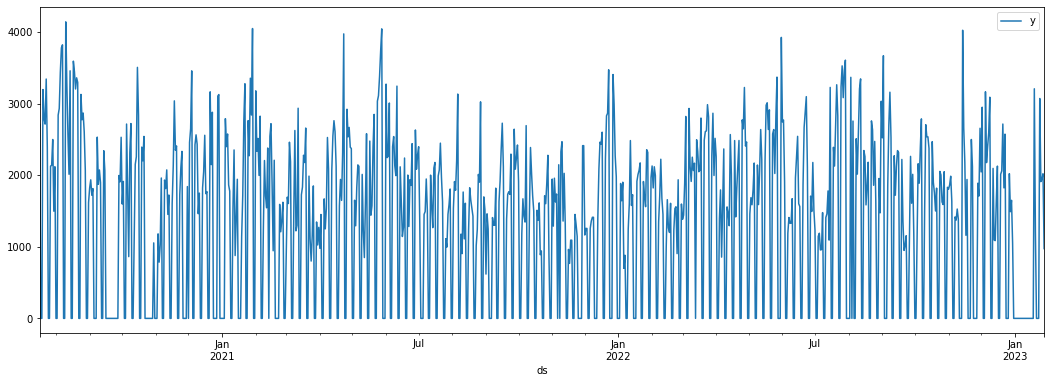

In [ ]:
df_FDC_Floor_pro.plot(x='ds',y='y',figsize=(18,6))

In [ ]:
m = Prophet()
m.fit(df_FDC_Floor_pro)
future = m.make_future_dataframe(periods=90) #MS for monthly, H for hourly
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Rmy\anaconda3\envs\steel\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Rmy\anaconda3\envs\steel\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Rmy\anaconda3\envs\steel\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1011,2023-04-24,1998.731923,1104.215504,2885.460326
1012,2023-04-25,2172.063006,1274.654639,3049.191037
1013,2023-04-26,2151.766210,1308.729910,3009.275228
1014,2023-04-27,2099.827745,1234.410989,2978.766920
1015,2023-04-28,2210.189731,1320.397111,3028.373323


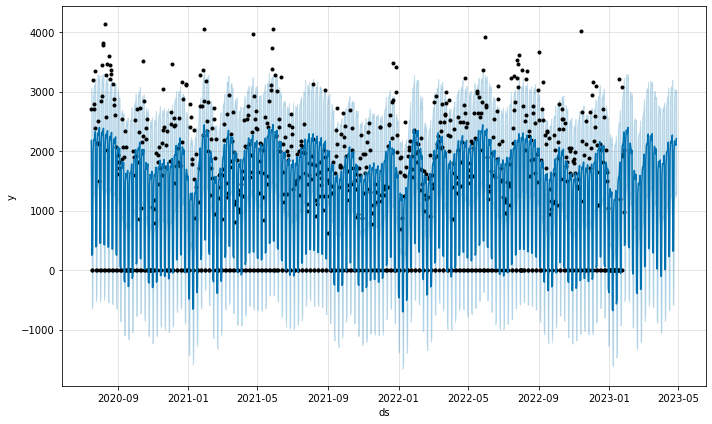

In [ ]:
fig1 = m.plot(forecast)

C:\Users\Rmy\anaconda3\envs\steel\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Rmy\anaconda3\envs\steel\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


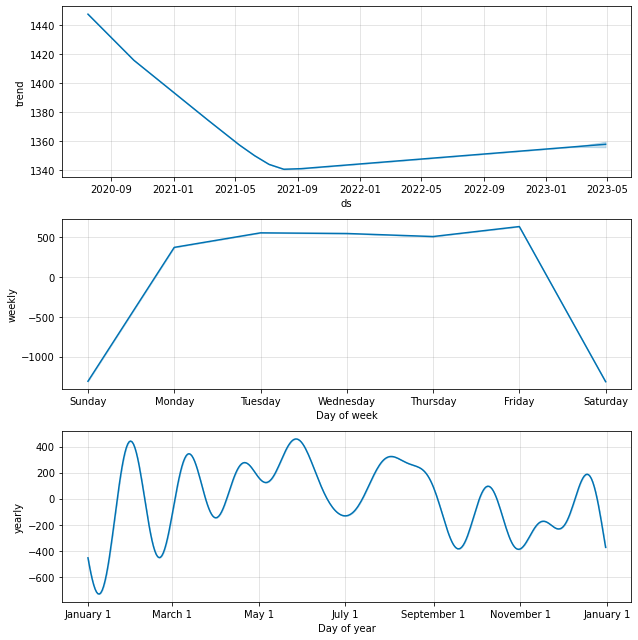

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
df_Total = df_Total.rename(columns={df_Total.columns[0]: 'Total_Date'})

## Save the dataframes to a SQLlite DB

In [ ]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('steelcase.db')

# Save the data frame to the database
df_FDC_Floor.to_sql('FDC_Floor', conn, if_exists='replace', index=False)
df_In_Transit.to_sql('In_Transit', conn, if_exists='replace', index=False)
df_RDC_Building.to_sql('RDC_Building', conn, if_exists='replace', index=False)
df_RDC_Inb__Yard.to_sql('RDC_Inb', conn, if_exists='replace', index=False)
df_RDC_Ob__Yard.to_sql('RDC_Ob', conn, if_exists='replace', index=False)
df_Sq_Ft_Used.to_sql('Sq_Ft_Used', conn, if_exists='replace', index=False)
df_Total.to_sql('Total', conn, if_exists='replace', index=False)

conn.close()

### SQL Lite Code to combine all the clean 2 years of daily inventory data

```
# This is formatted as code for SQL lite...Once the above code is completed we can either run this within python or separatly with 
SQLlite (DBviewer)

CREATE TABLE Steelcase_Daily_Inventory AS
SELECT 
FDC_Floor.'FDC Floor' as 'Steelcase_Date',
FDC_Floor.'Day_of_Week' as 'Day',
FDC_Floor.'weekend' as 'Weekend_Flag',
FDC_Floor.'is_holiday' as 'Holiday_Flag',
FDC_Floor.'Rancho' as 'Rancho_FDC_Floor',
FDC_Floor.'Hazleton' as 'Hazleton_FDC_Floor',
FDC_Floor.'Grand Rapids' as 'Grand Rapids_FDC_Floor',
FDC_Floor.'Atlanta' as 'Atlanta_FDC_Floor',
FDC_Floor.'DeSoto' as 'DeSoto_FDC_Floor',
FDC_Floor.'Aurora' as 'Aurora_FDC_Floor',
FDC_Floor.'Puyallup' as 'Puyallup_FDC_Floor',
In_Transit.'Rancho' as 'Rancho_In_Transit',
In_Transit.'Hazleton' as 'Hazleton_In_Transit',
In_Transit.'Grand Rapids' as 'Grand Rapids_In_Transit',
In_Transit.'Atlanta' as 'Atlanta_In_Transit',
In_Transit.'DeSoto' as 'DeSoto_In_Transit',
In_Transit.'Aurora' as 'Aurora_In_Transit',
In_Transit.'Puyallup' as 'Puyallup_In_Transit',
RDC_Building.'Rancho' as 'Rancho_RDC_Building',
RDC_Building.'Hazleton' as 'Hazleton_RDC_Building',
RDC_Building.'Grand Rapids' as 'Grand Rapids_RDC_Building',
RDC_Building.'Atlanta' as 'Atlanta_RDC_Building',
RDC_Building.'DeSoto' as 'DeSoto_RDC_Building',
RDC_Building.'Aurora' as 'Aurora_RDC_Building',
RDC_Building.'Puyallup' as 'Puyallup_RDC_Building',
RDC_Inb.'Rancho' as 'Rancho_RDC_Inb',
RDC_Inb.'Hazleton' as 'Hazleton_RDC_Inb',
RDC_Inb.'Grand Rapids' as 'Grand Rapids_RDC_Inb',
RDC_Inb.'Atlanta' as 'Atlanta_RDC_Inb',
RDC_Inb.'DeSoto' as 'DeSoto_RDC_Inb',
RDC_Inb.'Aurora' as 'Aurora_RDC_Inb',
RDC_Inb.'Puyallup' as 'Puyallup_RDC_Inb',
RDC_Ob.'Rancho' as 'Rancho_RDC_Ob',
RDC_Ob.'Hazleton' as 'Hazleton_RDC_Ob',
RDC_Ob.'Grand Rapids' as 'Grand Rapids_RDC_Ob',
RDC_Ob.'Atlanta' as 'Atlanta_RDC_Ob',
RDC_Ob.'DeSoto' as 'DeSoto_RDC_Ob',
RDC_Ob.'Aurora' as 'Aurora_RDC_Ob',
RDC_Ob.'Puyallup' as 'Puyallup_RDC_Ob',
Sq_Ft_Used.'Rancho' as 'Rancho_Sq_Ft_Used',
Sq_Ft_Used.'Hazleton' as 'Hazleton_Sq_Ft_Used',
Sq_Ft_Used.'Grand Rapids' as 'Grand Rapids_Sq_Ft_Used',
Sq_Ft_Used.'Atlanta' as 'Atlanta_Sq_Ft_Used',
Sq_Ft_Used.'DeSoto' as 'DeSoto_Sq_Ft_Used',
Sq_Ft_Used.'Aurora' as 'Aurora_Sq_Ft_Used',
Sq_Ft_Used.'Puyallup' as 'Puyallup_Sq_Ft_Used',
Total.'Rancho' as 'Rancho_Total',
Total.'Hazleton' as 'Hazleton_Total',
Total.'Grand Rapids' as 'Grand Rapids_Total',
Total.'Atlanta' as 'Atlanta_Total',
Total.'DeSoto' as 'DeSoto_Total',
Total.'Aurora' as 'Aurora_Total',
Total.'Puyallup' as 'Puyallup_Total'
FROM FDC_Floor
JOIN In_Transit ON FDC_Floor.'FDC Floor'= In_Transit.'In Transit'
JOIN RDC_Building ON FDC_Floor.'FDC Floor'= RDC_Building.'RDC Building'
JOIN RDC_Inb ON FDC_Floor.'FDC Floor'= RDC_Inb.'RDC Inb_ Yard'
JOIN RDC_Ob ON FDC_Floor.'FDC Floor'= RDC_Ob.'RDC Ob_ Yard'
JOIN Sq_Ft_Used ON FDC_Floor.'FDC Floor'= Sq_Ft_Used.'Sq Ft Used'
JOIN Total ON FDC_Floor.'FDC Floor'= Total.'Total_Date'
```





```
# This is formatted as code
MODIFY TABLE "Steelcase_Daily_Inventory" (
	"Steelcase_Date"	NUM,
	"Day"	TEXT,
	"Weekend_Flag"	INT,
	"Holiday_Flag"	INT,
	"Rancho_FDC_Floor"	INT,
	"Rancho_In_Transit"	INT,
	"Rancho_RDC_Inb"	INT,
	"Rancho_RDC_Building"	INT,
	"Rancho_RDC_Ob"	INT,
	"Rancho_Total"	INT,
	"Rancho_Sq_Ft_Used"	REAL,
	"Hazleton_FDC_Floor"	INT,
	"Hazleton_In_Transit"	INT,
	"Hazleton_RDC_Inb"	INT,
	"Hazleton_RDC_Building"	INT,
	"Hazleton_RDC_Ob"	INT,
	"Hazleton_Total"	INT,
	"Hazleton_Sq_Ft_Used"	REAL,
	"Grand Rapids_FDC_Floor"	INT,
	"Grand Rapids_In_Transit"	INT,
	"Grand Rapids_RDC_Inb"	INT,
	"Grand Rapids_RDC_Building"	INT,
	"Grand Rapids_RDC_Ob"	INT,
	"Grand Rapids_Total"	INT,
	"Grand Rapids_Sq_Ft_Used"	REAL,
	"Atlanta_FDC_Floor"	INT,
	"Atlanta_In_Transit"	INT,
	"Atlanta_RDC_Inb"	INT,
	"Atlanta_RDC_Building"	INT,
	"Atlanta_RDC_Ob"	INT,
	"Atlanta_Total"	INT,
	"Atlanta_Sq_Ft_Used"	REAL,
	"DeSoto_FDC_Floor"	INT,
	"DeSoto_In_Transit"	INT,
	"DeSoto_RDC_Inb"	INT,
	"DeSoto_RDC_Building"	INT,
	"DeSoto_RDC_Ob"	INT,
	"DeSoto_Total"	INT,
	"DeSoto_Sq_Ft_Used"	REAL,
	"Puyallup_FDC_Floor"	INT,
	"Puyallup_In_Transit"	INT,
	"Puyallup_RDC_Inb"	INT,
	"Puyallup_RDC_Building"	INT,
	"Puyallup_RDC_Ob"	INT,
	"Puyallup_Sq_Ft_Used"	REAL,
	"Puyallup_Total"	INT,
	"Aurora_FDC_Floor"	INT,
	"Aurora_In_Transit"	INT,
	"Aurora_RDC_Inb"	INT,
	"Aurora_RDC_Building"	INT,
	"Aurora_RDC_Ob"	INT,
	"Aurora_Total"	INT,
	"Aurora_Sq_Ft_Used"	REAL
);
```





```
# This is formatted as code

CREATE TABLE Steelcase_Daily_Inventory_v1 AS
SELECT *,
CASE
    WHEN Rancho_FDC_Floor = 0 AND Hazleton_FDC_Floor = 0 AND "Grand Rapids_RDC_Building" = 0 AND Atlanta_FDC_Floor = 0 THEN 0
    ELSE 1
END AS flag_no_values
FROM Steelcase_Daily_Inventory;
```

